# Multinomial processing model of pair clustering

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np

import keras
import bayesflow as bf

### Simulator

In [ ]:
def context():
    return dict(n=np.random.randint(10, 1001))

def prior():
    return dict(
        c = np.random.beta(a=1, b=1),
        r = np.random.beta(a=1, b=1),
        u = np.random.beta(a=1, b=1)
    )

def likelihood(c, r, u, n):
    theta = [c*r, (1-c)*u**2, 2*u*(1-c)*(1-u), c*(1-r) + (1-c)*(1-u)**2]

    k = np.random.multinomial(n=n, pvals=theta)

    return dict(k=k)

simulator = bf.make_simulator([context, prior, likelihood])

(10, 4)

### Approximator

We will use the `BasicWorkflow` to aproximate the posterior of $c$, $r$,
and $u$, given sample size $n$ and observed responses $k$.

We will also make sure that the constraints of the parameters (which all
live on the interval between 0 and 1) are respected.

In [ ]:
adapter = (bf.Adapter()
    .constrain(["c", "r", "u"], lower=0, upper=1)
    .concatenate(["c", "r", "u"], into="inference_variables")
    .concatenate(["n", "k"], into="inference_conditions")
)

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow()
)

### Training

In [ ]:
history=workflow.fit_online(epochs=20, num_batches_per_epoch=100, batch_size=256)

### Validation

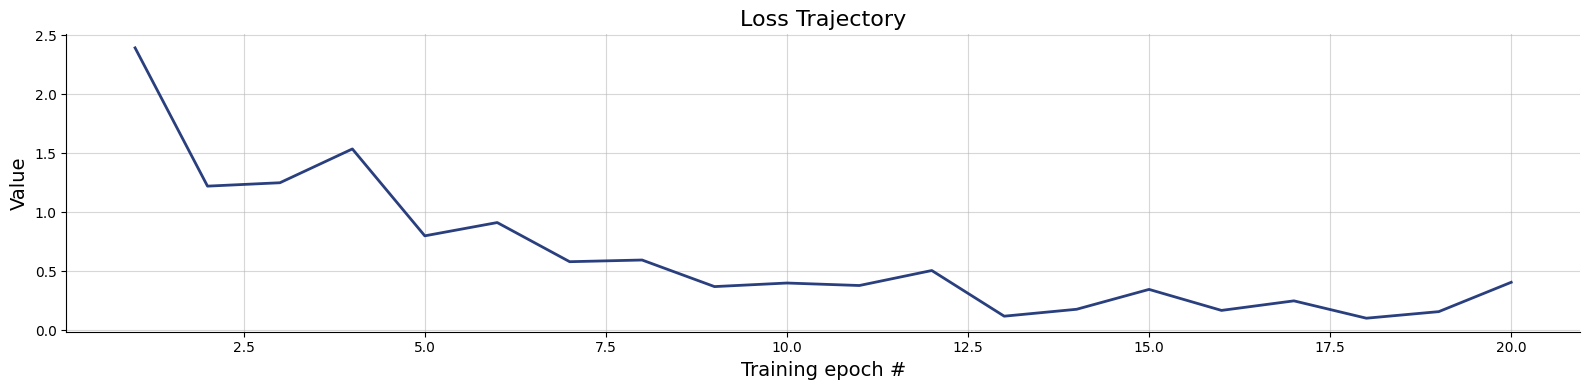

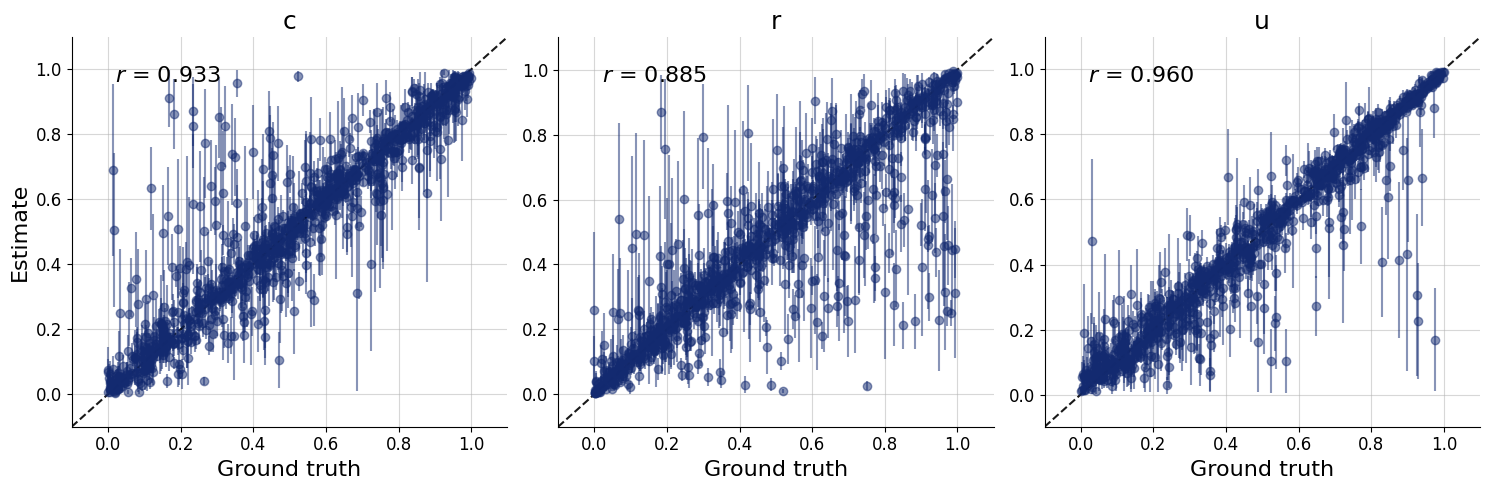

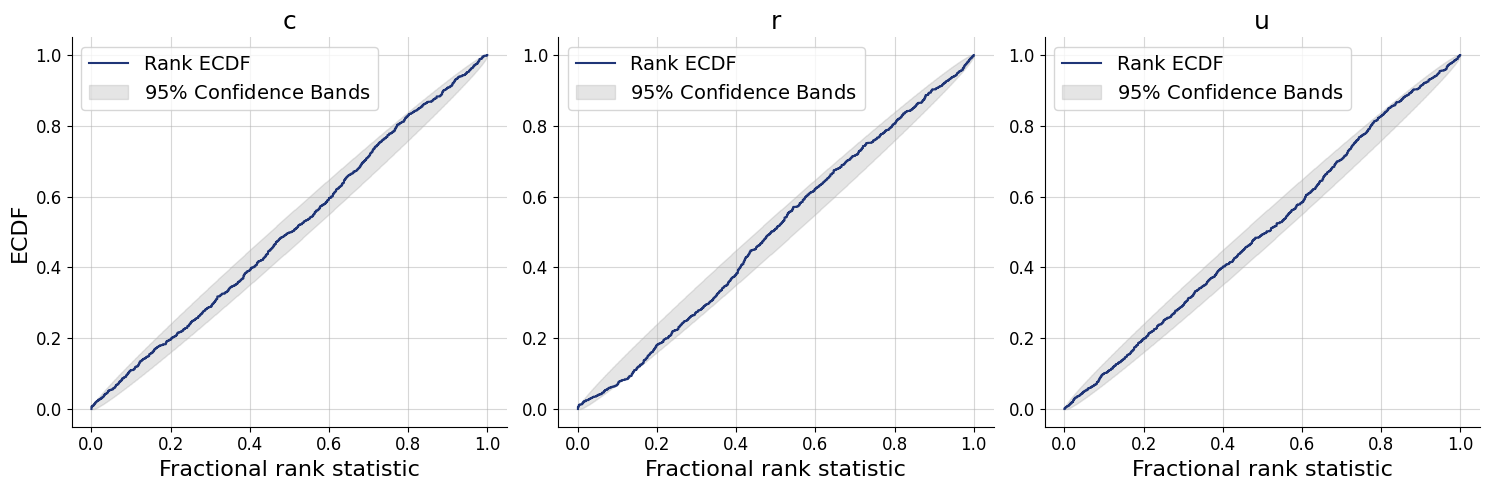

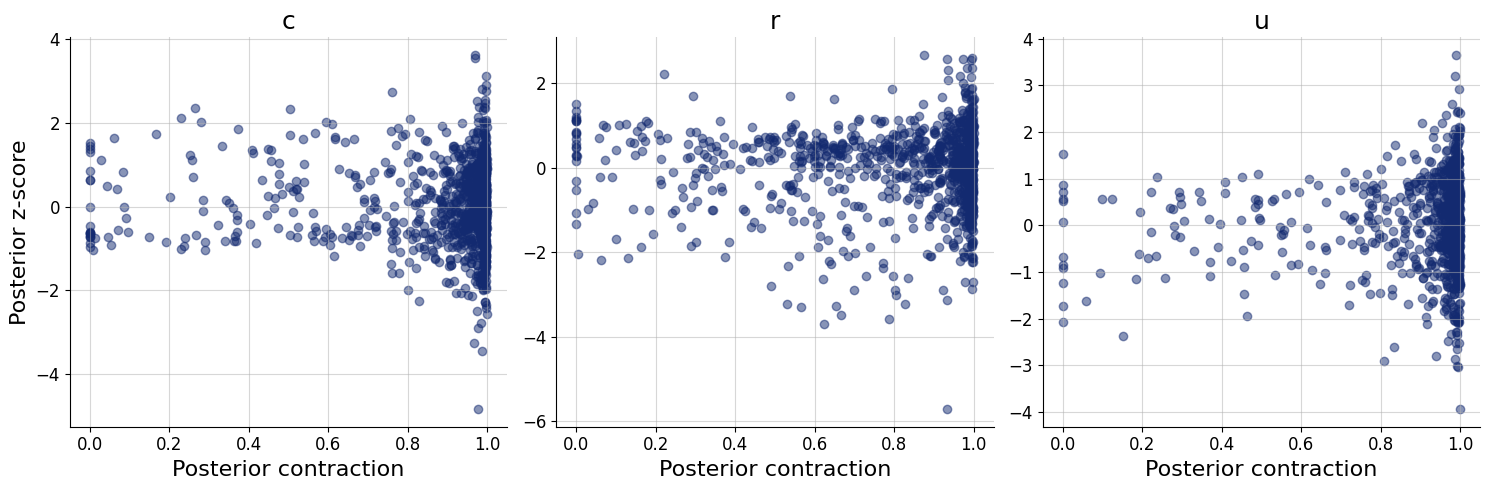

In [9]:
test_data = simulator.sample(1000)
figs=workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

Here we will obtain the posterior distributions for trials 1, 2, and 6
from Riefer et al. (2002) as reported by Lee & Wagenmakers (2013).

In [16]:
k = np.array([
    [45, 24, 97, 254],
    [106, 41, 107, 166],
    [243, 64, 65, 48]
])
inference_data = dict(k=k, n=np.sum(k, axis=-1)[..., np.newaxis])

In [ ]:
posterior_samples = workflow.sample(num_samples=2000, conditions=inference_data)

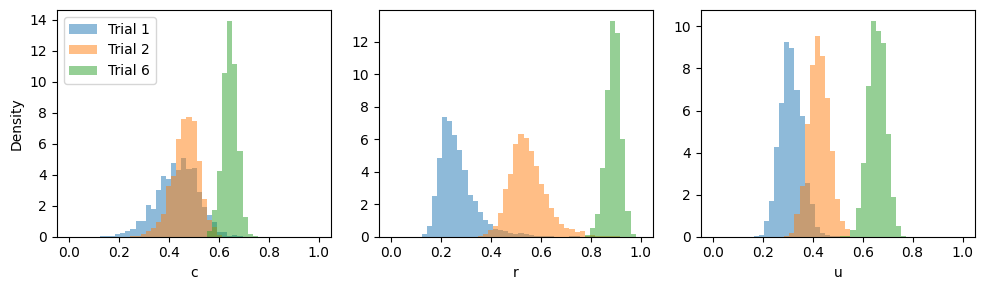

In [33]:
plt.rcParams['figure.figsize'] = [10, 3]
fig, axes = plt.subplots(ncols=3)
axes = axes.flatten()
labels = ["Trial 1", "Trial 2", "Trial 6"]

for dat in range(len(labels)):
    for i, (par, samples)  in enumerate(posterior_samples.items()):
        axes[i].hist(samples[dat].flatten(), density=True, alpha=0.5, bins = np.linspace(0, 1, 50))
        axes[i].set_xlabel(par)
axes[0].legend(labels)
axes[0].set_ylabel("Density")


fig.tight_layout()

Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.

Riefer, D. M., Knapp, B. R., Batchelder, W. H., Bamber, D., & Manifold,
V. (2002). Cognitive psychometrics: Assessing storage and retrieval
deficits in special populations with multinomial processing tree models.
*Psychological Assessment*, *14*(2), 184.